jupyter labextension install jupyterlab-plotly@4.14.3

## Helper Functions

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from tslearn.clustering import TimeSeriesKMeans
pd.options.plotting.backend = "plotly"

import sys
sys.path.append('../')

from src.visualization.visualize import PlotlyHelper
from src.features.build_features import Transform, Weekly

C:\Users\cjl-school\miniconda3\envs\main\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Importing Data

In [2]:
data = pd.read_parquet('../data/interim/case_count.parquet')
data

,76574,78605,78610,78612,78613,78615,78616,78617,78620,78621,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
2020-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-02,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,2.0,0.0,2.0,1.0,7.0,0.0,1.0,1.0,5.0,7.0
2021-04-03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,2.0,0.0,4.0,0.0,2.0,8.0,3.0,3.0
2021-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## KMeans Clustering w/ Sklearn

In [9]:
def KMeansC(data,norm=False,n_clusters=8, ylabel='Cases',line_label='Zip_Code',dtw=False,elbow_only=False):
    xlabel = data.index.name
    data.dropna(inplace=True)
    if norm:
        train_data, scaler = Transform.normalize(data)
        train_data = train_data.dropna()
    else:
        train_data = data
    
    if dtw:
        model = TimeSeriesKMeans(n_clusters=8, metric="dtw", max_iter=100).fit(train_data.T)
    else:
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(train_data.T)
    
    
    clusters = model.predict(train_data.T)
    if elbow_only:
        return model.inertia_
    trace_cluster = {trace:cluster_num for trace, cluster_num in zip(data.columns,clusters)}
    df = pd.DataFrame(data.stack()).reset_index().rename(columns={'level_1':line_label,0:ylabel}).set_index(xlabel)
    
    df['Cluster'] = [trace_cluster[trace] for trace in df[line_label]]
    
    fig=px.line(df,y=ylabel,line_group=line_label,color='Cluster')
    
    
#     if norm:
#         fig.show()
#     else:
    fig,cluster_color=PlotlyHelper.recolor(fig)
    fig3 = PlotlyHelper.plot_cluster_center(model,train_data,fig, cluster_color, df)
    fig3.show()
    
    results = {'df':df,'model':model,'train_data':train_data}
    return results





def zip_weekly_profile(zip_code):
    results2 = KMeansC(Weekly.pivot_day_of_week(data[str(zip_code)],zip_code).fillna(0),ylabel='Cases',line_label='Week of')
    df2=results2['df']
    df2.plot(x='Week of',y=df2['Cluster'],kind='scatter',color=df2['Cluster'].astype(str)).show()
    return df2

In [18]:
distortions = []
for n in range(1,10):
    distortions.append(KMeansC(data, n_clusters=n,elbow_only=True))

In [13]:
distortions = []
for n in range(1,10):
    distortions.append(KMeansC(data.resample('7D').mean(), n_clusters=n,elbow_only=True))

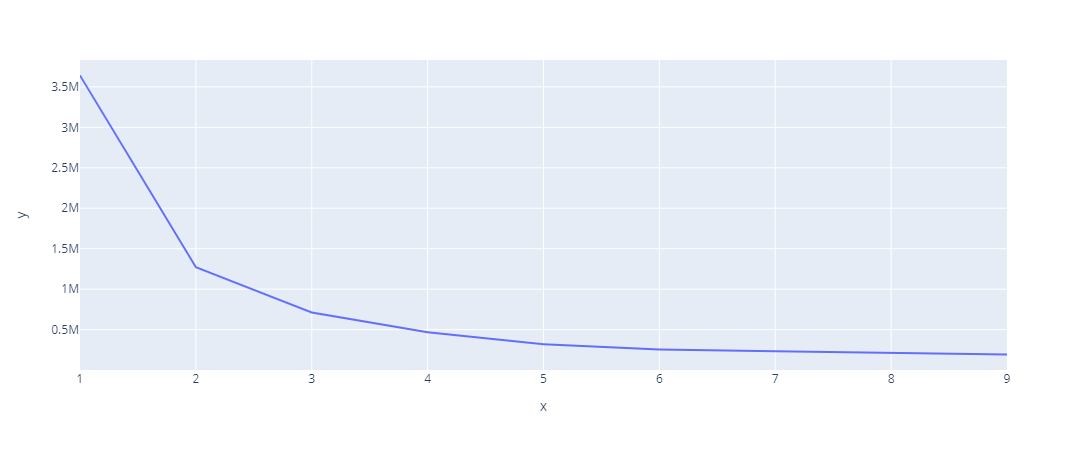

In [19]:
x = [1,2,3,4,5,6,7,8,9]
px.line(x=x,y=distortions)

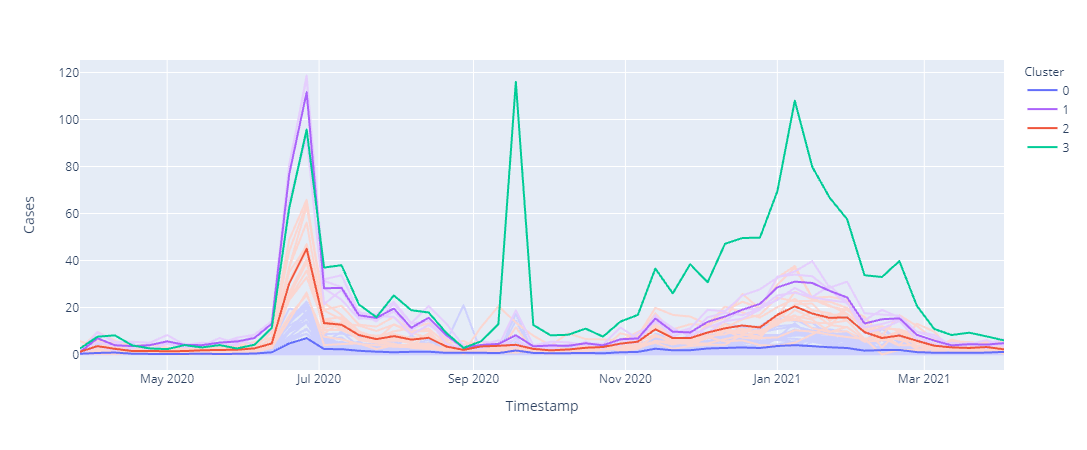

In [20]:
results = KMeansC(data.resample('7D').mean(), n_clusters=4)

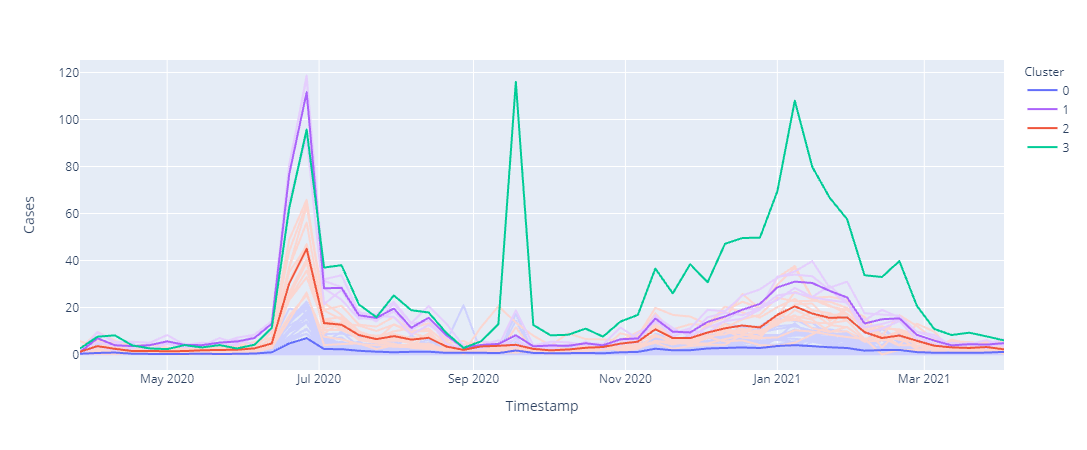

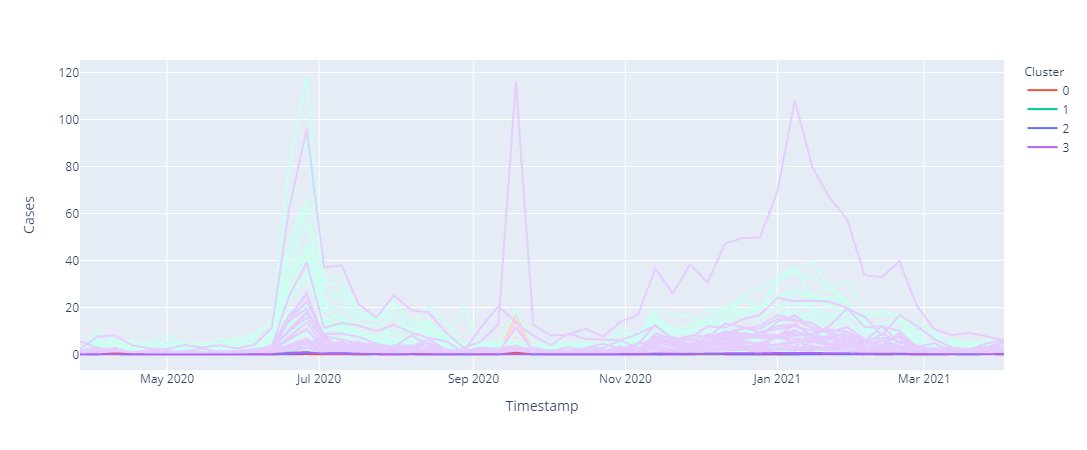

C:\Users\cjl-school\miniconda3\envs\main\lib\site-packages\tslearn\utils\utils.py:88: UserWarning:

2-Dimensional data passed. Assuming these are 71 1-dimensional timeseries



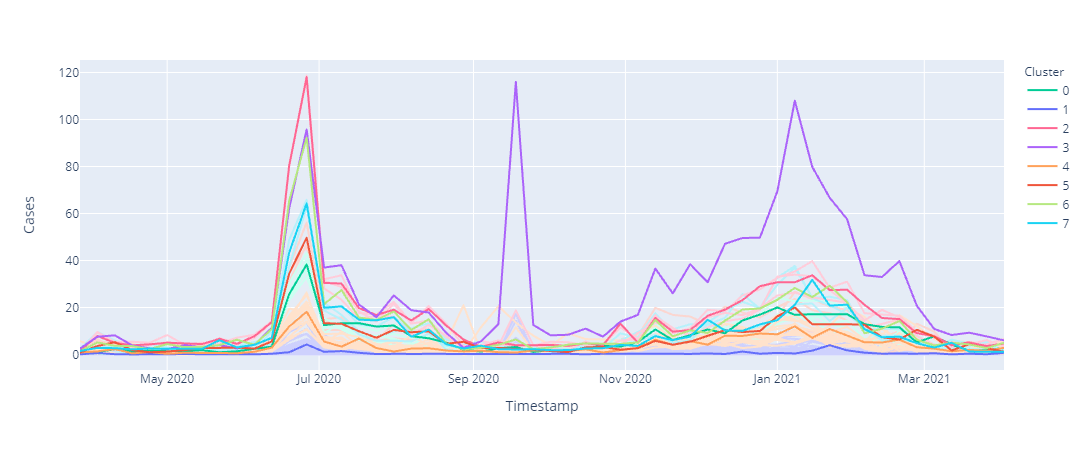

C:\Users\cjl-school\miniconda3\envs\main\lib\site-packages\tslearn\utils\utils.py:88: UserWarning:

2-Dimensional data passed. Assuming these are 71 1-dimensional timeseries



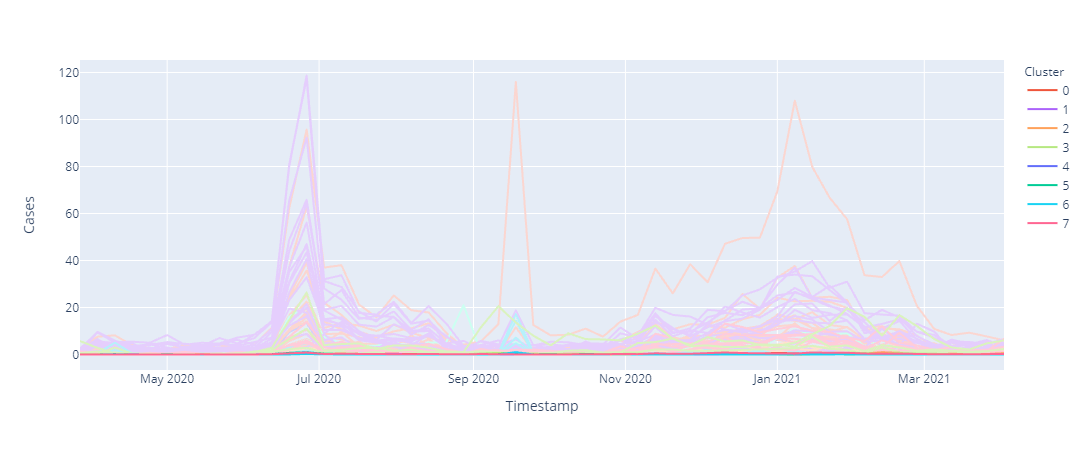

In [21]:
results = KMeansC(data.resample('7D').mean(), n_clusters=4)
results = KMeansC(data.resample('7D').mean(), n_clusters=4, norm=True)
results = KMeansC(data.resample('7D').mean(), n_clusters=4, dtw=True)
results = KMeansC(data.resample('7D').mean(), n_clusters=4, norm=True,dtw=True)

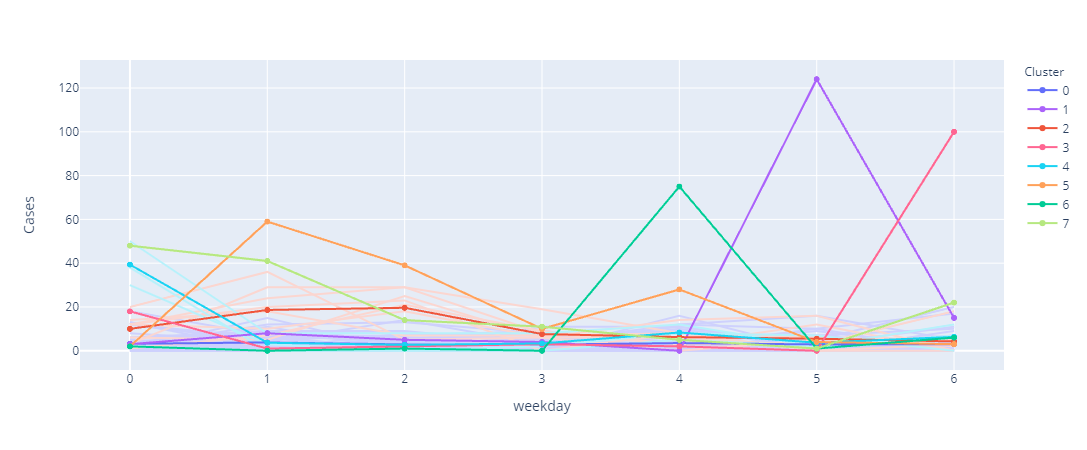

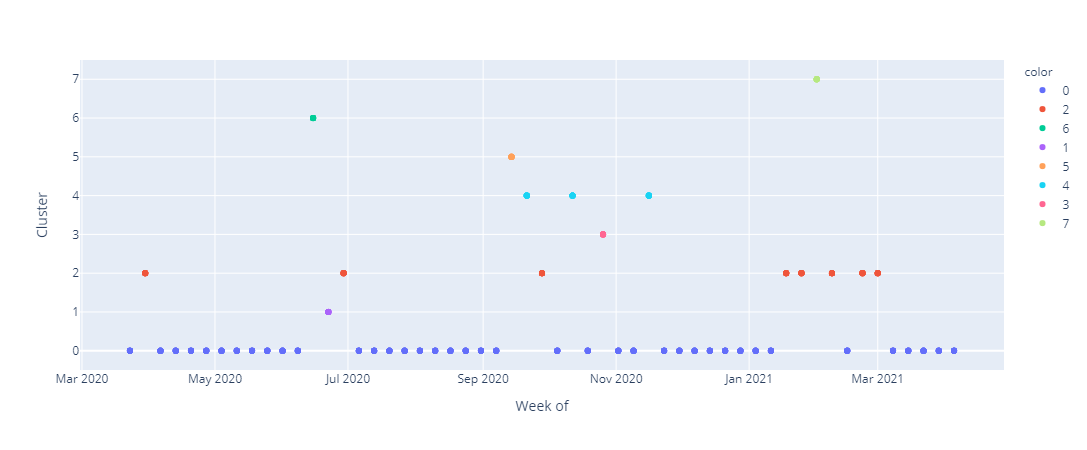

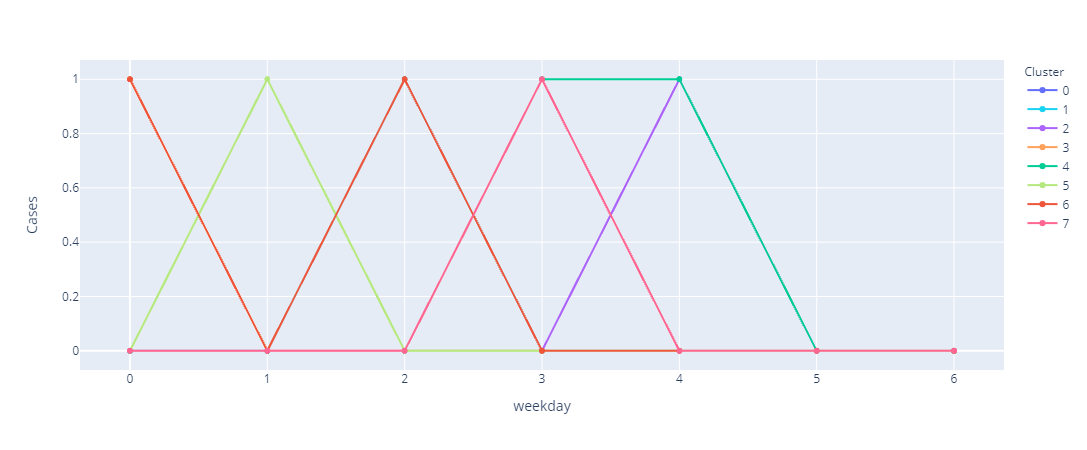

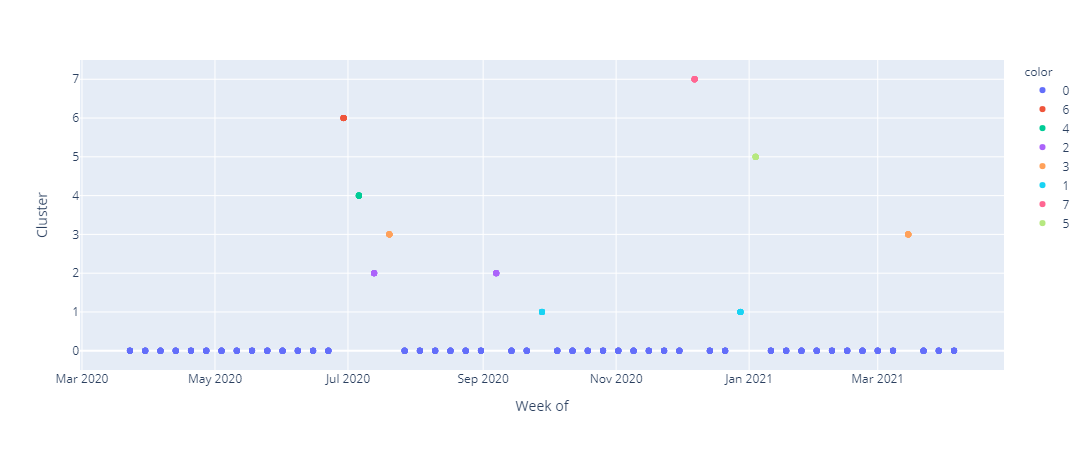

Index(['76574', '78605', '78610', '78612', '78613', '78615', '78616', '78617',
       '78620', '78621', '78626', '78628', '78634', '78640', '78641', '78642',
       '78644', '78645', '78652', '78653', '78654', '78660', '78663', '78664',
       '78665', '78669', '78681', '78701', '78702', '78703', '78704', '78705',
       '78712', '78717', '78719', '78721', '78722', '78723', '78724', '78725',
       '78726', '78727', '78728', '78729', '78730', '78731', '78732', '78733',
       '78734', '78735', '78736', '78737', '78738', '78739', '78741', '78742',
       '78744', '78745', '78746', '78747', '78748', '78749', '78750', '78751',
       '78752', '78753', '78754', '78756', '78757', '78758', '78759'],
      dtype='object')

In [6]:
zip_weekly_profile('78705')
zip_weekly_profile('76574')


# weekly = pd.concat([zip_weekly_profile(zip_code) for zip_code in data.columns],axis=1)  
data.columns